In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint, permutation
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy.interpolate import griddata

import scipy.io as sio
from scipy.fft import fft, ifft, fftfreq

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
%config InlineBackend.figure_format = 'retina'

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# Colormap for segmentation
cm = plt.get_cmap('Set1')

# Optionally, set cluster zero to white
new_cm = np.zeros((cm.N+1, 4))
new_cm[1:, :] = cm(np.arange(cm.N))
new_cm[0, :] = [1, 1, 1, 1]
new_cm = np.delete(new_cm, 6, axis=0)  # Delete yellow
cm_white = ListedColormap(new_cm)

cb2_list = ['#ffffff','#4daf4a','#ff7f00','#377eb8','#984ea3','#e41a1c','#a65628','#f781bf','#999999']
cb2_cmap = ListedColormap(cb2_list)

cm = cb2_cmap

# Wave nucleation

In [2]:
data = sio.loadmat('nucleation.mat')
u = data['u']
z = data['z'] # Combustion variable
t = data['t'][0]
x = data['x'][0]
D = data['D'][0][0]
L = data['L'][0][0]
s = data['s'][0][0]
nu = data['nu'][0][0]

dx = x[1]-x[0]
dt = t[1]-t[0]
N = len(x)

mask = np.nonzero(t>3)[0]
t = t[mask]
u = u[:, mask]
z = z[:, mask]

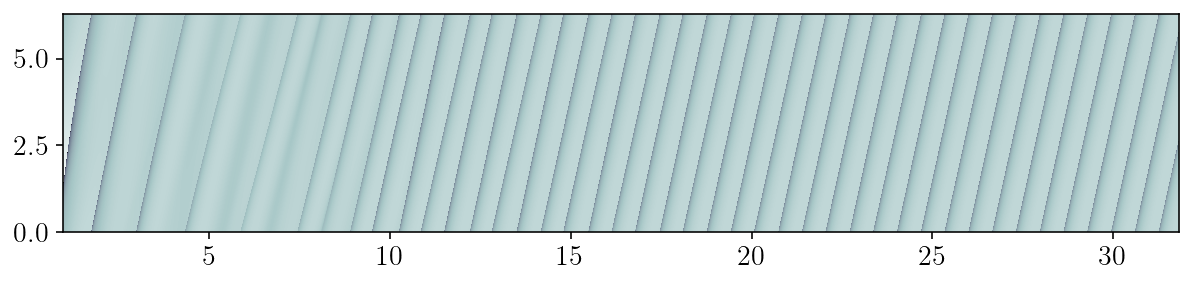

In [3]:
tau = t*D/L

fig, ax0 = plt.subplots(nrows=1, figsize=(10, 2))
im = ax0.pcolormesh(tau, x, u, cmap='bone_r', shading='auto')
#plt.xlim([0, 30])

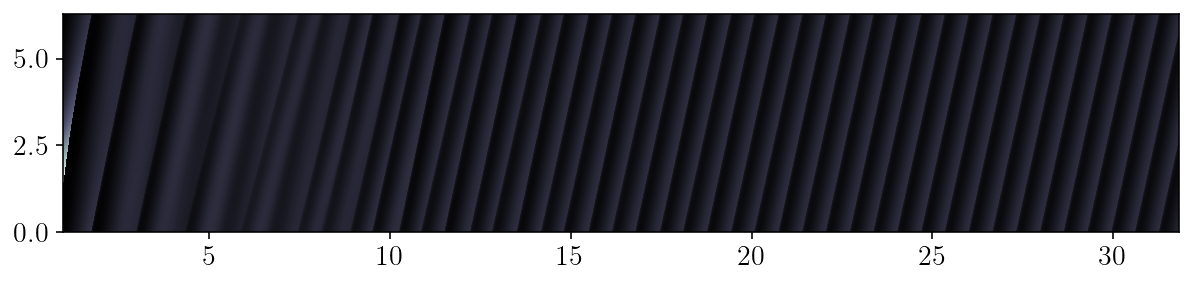

In [4]:
fig, ax0 = plt.subplots(nrows=1, figsize=(10, 2))
im = ax0.pcolormesh(tau, x, z, cmap='bone_r', shading='auto')
#plt.xlim([0, 30])

In [5]:
# Compute derivatives
k = 2*np.pi*fftfreq(N, dx)

ux = np.zeros(u.shape)
#uxx = np.zeros(u.shape)
ut = np.zeros(u.shape)
for i in range(len(t)):
    ux[:, i] = np.gradient(u[:, i], dx)
    #uxx[:, i] = np.gradient(ux[:, i], dx)
    #ux[:, i] = np.real( ifft( (1j*k*fft(u[:, i])) ) )
    
for i in range(len(x)):
    ut[i, :] = np.gradient(u[i, :], dt)

### Align the fields

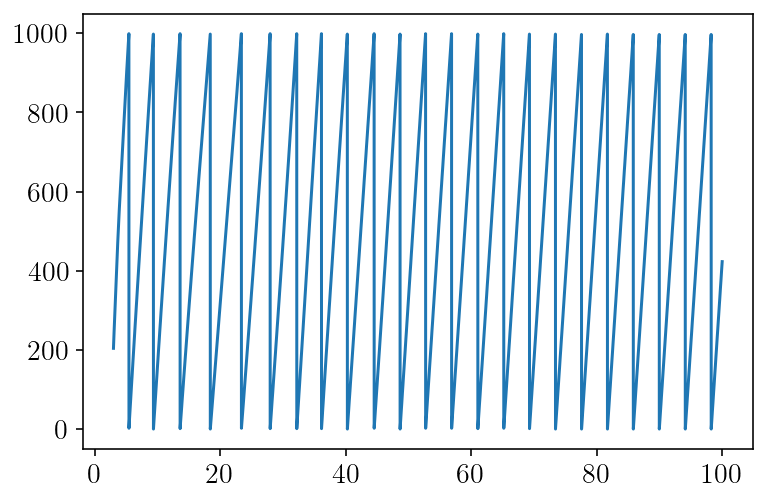

In [6]:
max_idx = np.zeros(len(t), dtype=int)
max_idx[0] = np.argmax(u[:, 0])

window = 20
for i in range(1, len(t)):
    idx_range = np.mod( np.arange(max_idx[i-1]-window, max_idx[i-1]+window, dtype=int), N)
    max_idx[i] = idx_range[ np.argmax(u[idx_range, i]) ]
    
plt.plot(t, max_idx)

In [7]:
offset = 50
for i in range(len(t)):
    idx_range = np.mod( np.arange(N, dtype=int) + max_idx[i] - offset, N)
    u[:, i] = u[idx_range, i]
    ut[:, i] = ut[idx_range, i]
    ux[:, i] = ux[idx_range, i]
    #uxx[:, i] = uxx[idx_range, i]
    z[:, i] = z[idx_range, i]
    

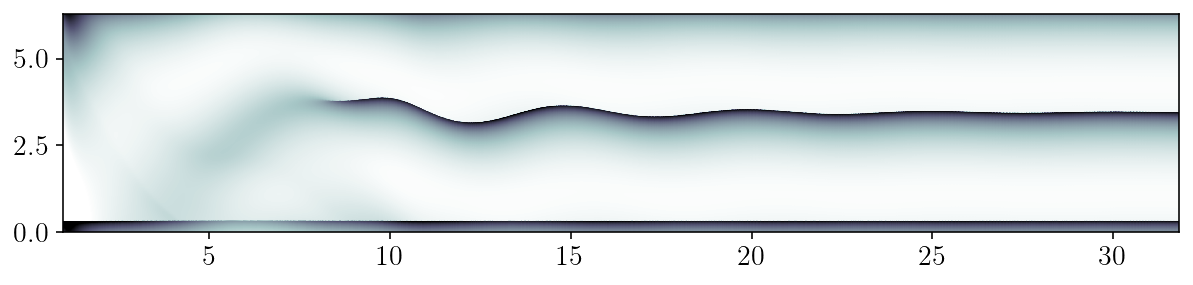

In [8]:
fig, ax0 = plt.subplots(nrows=1, figsize=(10, 2))
im = ax0.pcolormesh(tau, x, u, cmap='bone_r', shading='auto', vmin=1, vmax=2)

In [9]:
# Parameters
a = 0.3
uc = 1.1
up = 0.5
k = 5
e = 0.11

gain = (1-z)*np.exp( (u - uc)/a )
loss = -e*u**2

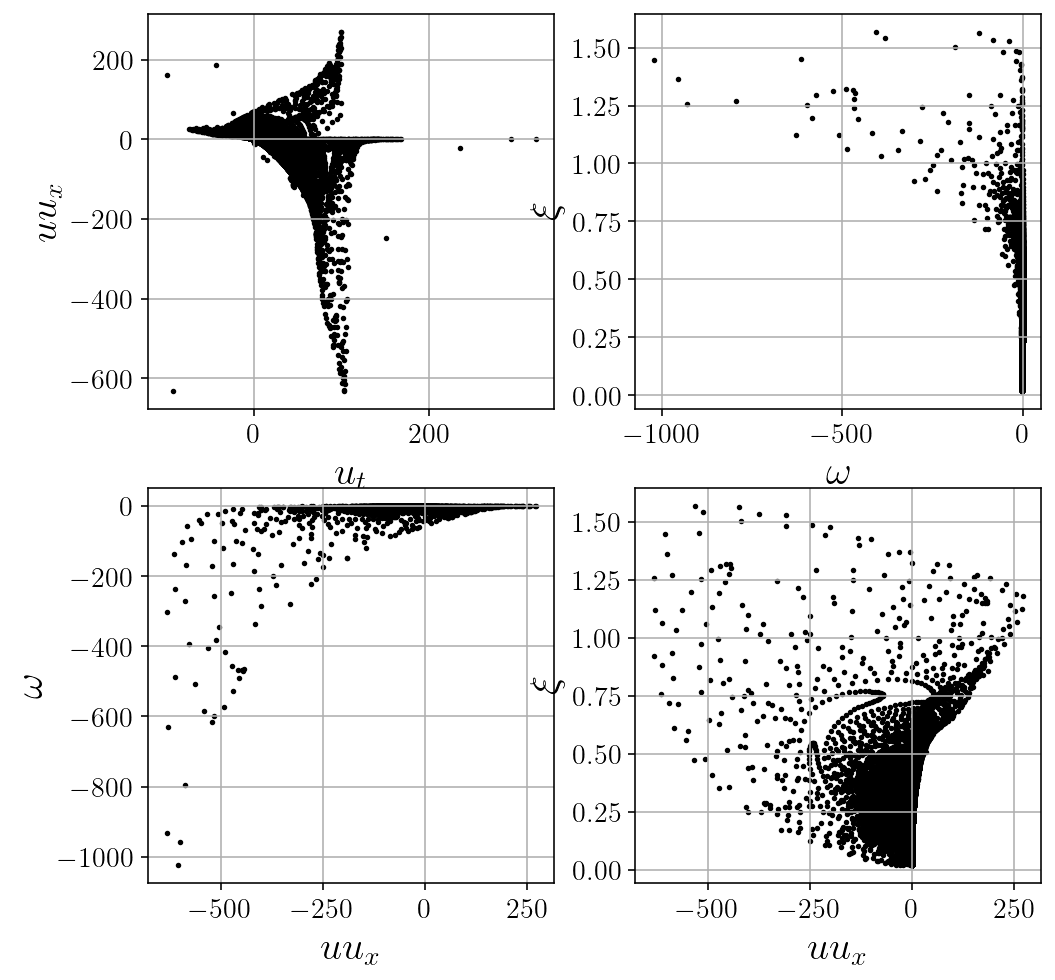

In [10]:
# features are [acceleration, advection, viscous]
features = np.vstack([ut.flatten(),
                      (u*ux).flatten(),
                      -gain.flatten(),
                      -loss.flatten()]).T
                      #-nu*uxx.flatten()]).T
nfeatures = features.shape[1]
labels = ['$u_t$', '$u u_x$', r'$\omega$', r'$\xi$']#, r'$\nu u_{xx}$']

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.scatter(features[:, 0], features[:,1], 3, 'k')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()

plt.subplot(222)
plt.scatter(features[:, 2], features[:,3], 3, 'k')
plt.xlabel(labels[2])
plt.ylabel(labels[3])
plt.grid()

plt.subplot(223)
plt.scatter(features[:, 1], features[:,2], 3, 'k')
plt.xlabel(labels[1])
plt.ylabel(labels[2])
plt.grid()

plt.subplot(224)
plt.scatter(features[:, 1], features[:,3], 3, 'k')
plt.xlabel(labels[1])
plt.ylabel(labels[3])
plt.grid()

plt.show()

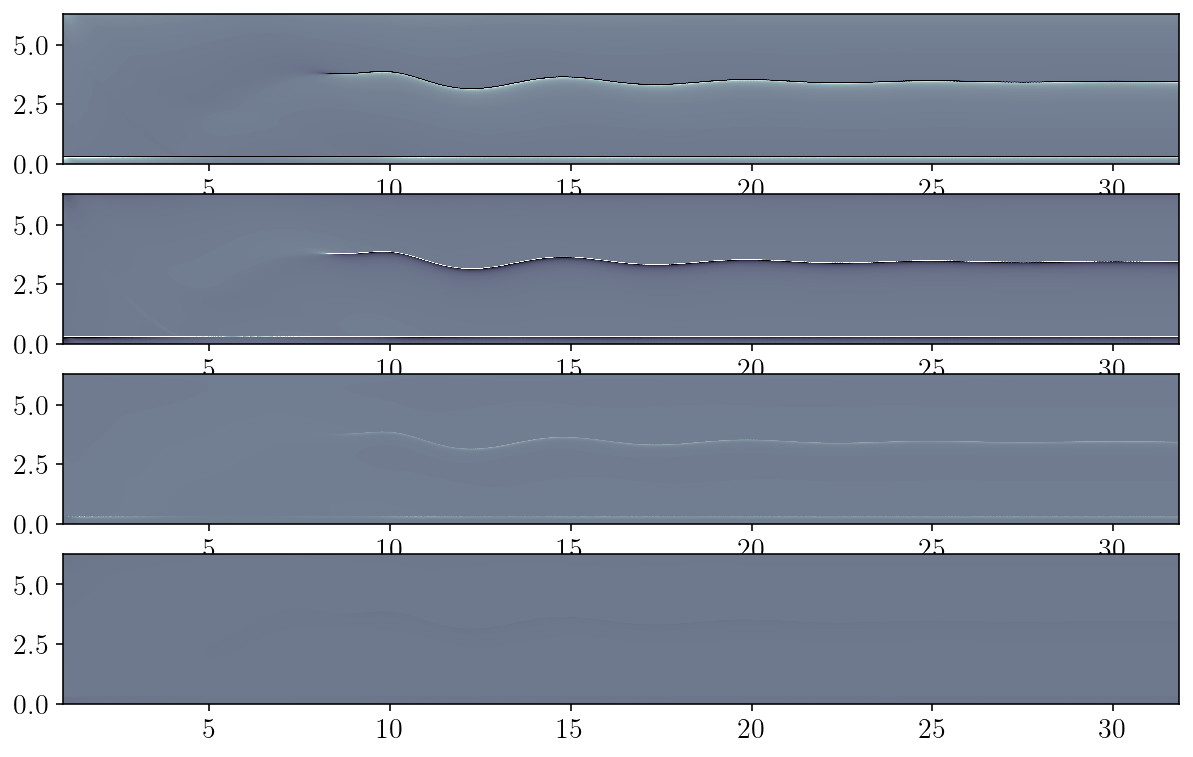

In [11]:
# Plot fields
plt.figure(figsize=(10, 8))

for i in range(4):
    plt.subplot(5, 1, i+1)
    field = np.reshape(features[:, i], [len(x), len(t)])
    plt.pcolormesh(tau, x, field, cmap='bone_r', shading='auto',
                  vmin =-10, vmax=10)

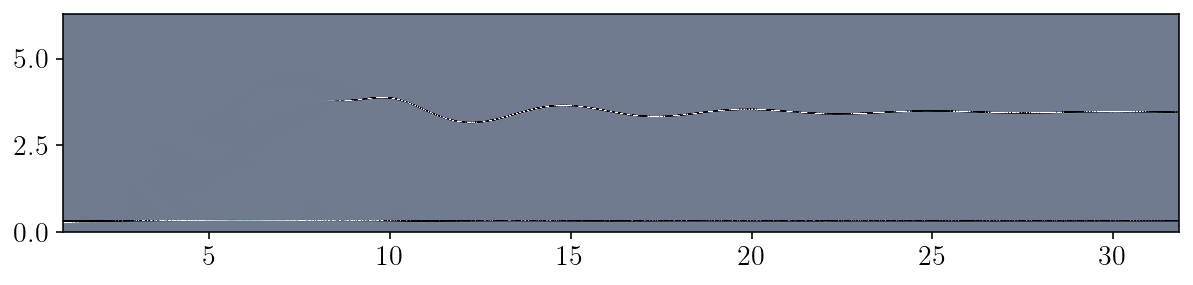

In [12]:
# check closure
# Plot fields
plt.figure(figsize=(10, 2))
field = np.reshape(np.sum(features, axis=1), [len(x), len(t)])
plt.pcolormesh(tau, x, field, cmap='bone_r', shading='auto',
              vmin =-10, vmax=10)

In [13]:
nc = 8  # Number of clusters

seed = np.random.randint(2**32)
seed = 913296044  # Random seed (nc=8)
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed)

# Randomly subsample data
sample_pct = 0.1
# PERMUTATION
rand_sample = permutation(features.shape[0])[:int(sample_pct*features.shape[0])]
model.fit(features[rand_sample, :])

913296044


GaussianMixture(n_components=8, random_state=913296044)

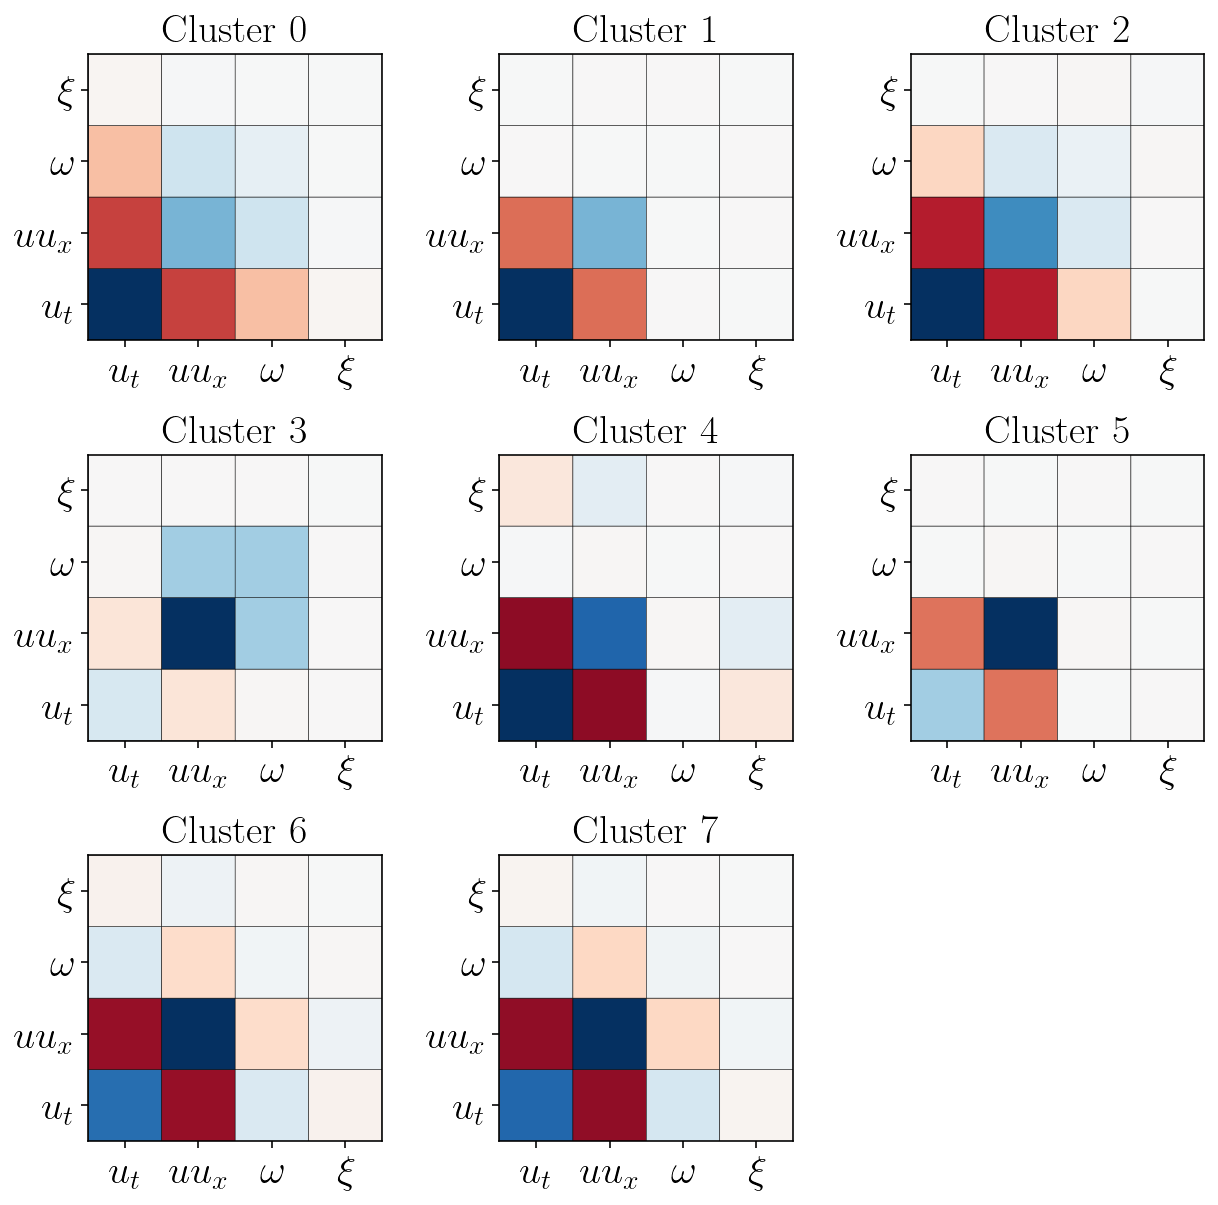

In [14]:
# Plot covariance matrices
plt.figure(figsize=(10, 10))
for i in range(nc):
    plt.subplot(3, 3, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu', edgecolors='k')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels, fontsize=20)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticklabels(labels, fontsize=20)
    plt.gca().set_title('Cluster {0}'.format(i))
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

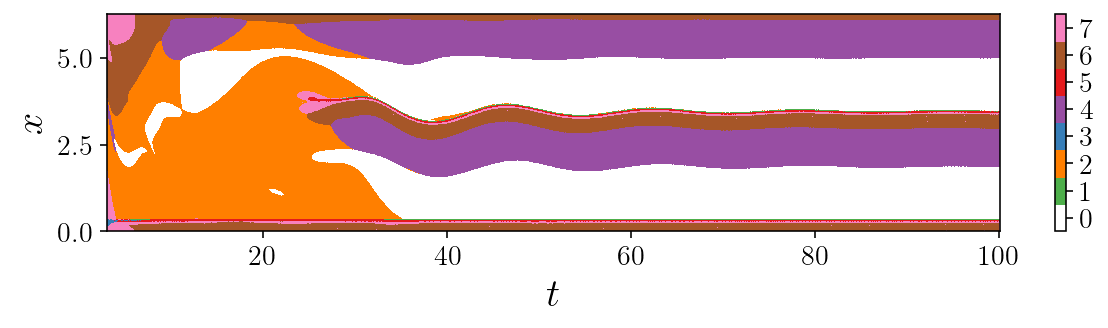

In [15]:
# Colormap of clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [len(x), len(t)])

plt.figure(figsize=(10, 2))
plt.pcolor(t, x, clustermap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, shading='auto')
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.colorbar(boundaries=np.arange(-0.5, nc+0.5), ticks=np.arange(0, nc))
#plt.xlim([-0.3, 2])
#plt.ylim([0, 0.04])
plt.show()

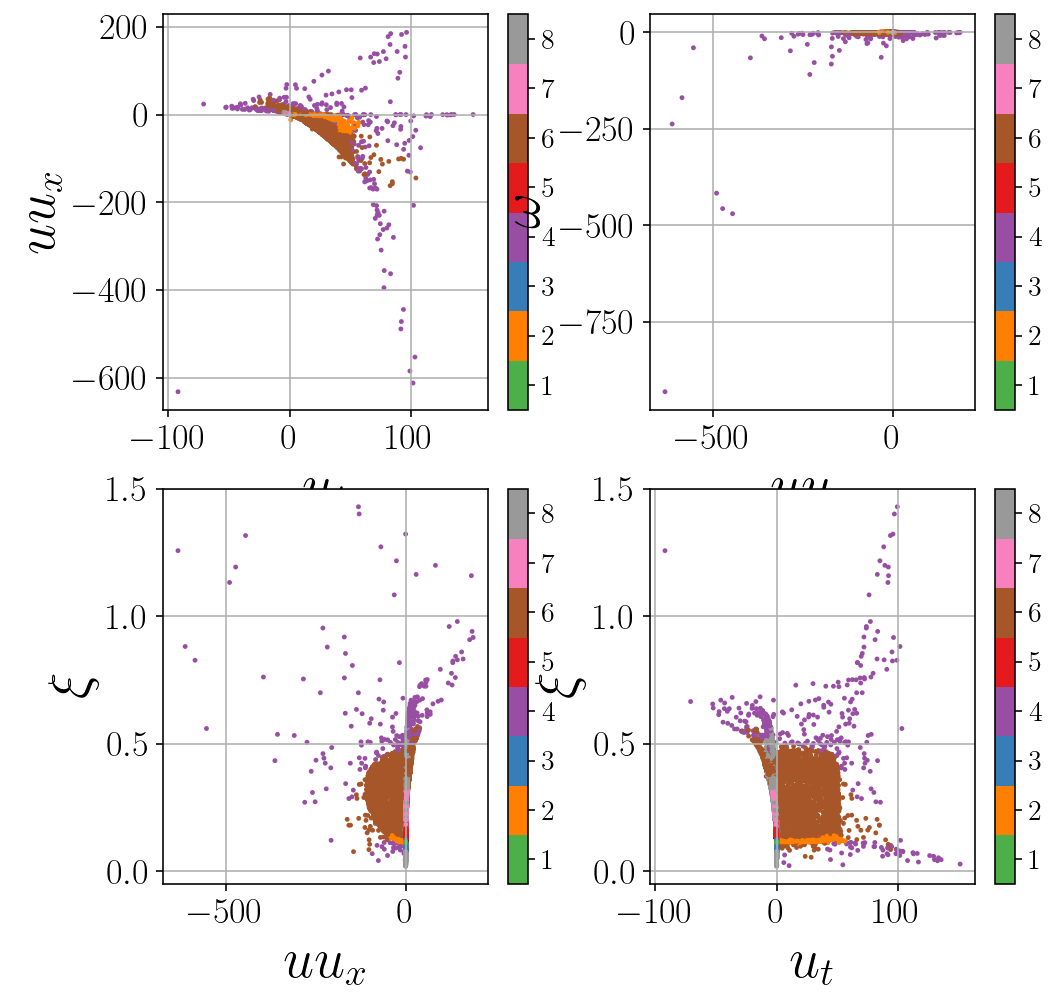

In [16]:
markersize = 2
fontsize = 28
# 2D views of feature space

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.scatter(features[rand_sample, 0], features[rand_sample,1], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[1], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()


plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[rand_sample, 1], features[rand_sample,2], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[1], fontsize=fontsize)
plt.ylabel(labels[2], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(223)
plt.scatter(features[rand_sample, 1], features[rand_sample,3], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[1], fontsize=fontsize)
plt.ylabel(labels[3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(224)
plt.scatter(features[rand_sample, 0], features[rand_sample,3], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.show()

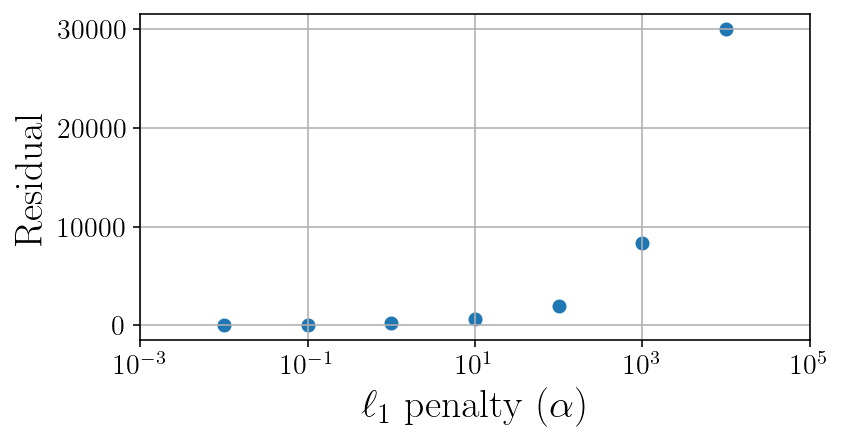

In [17]:
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]  # L1 regularization terms
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        # Fit the SPCA model using only the points in this GMM cluster
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])
        spca.fit(cluster_features)
        
        # Find directions in equation space with nonzero variance for the first principal component
        #   (These correspond to active terms in this region)
        active_terms = np.nonzero(spca.components_[0])[0]
        
        # The residual is defined as the norm of what was discarded
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ penalty ($\alpha$)')
plt.ylabel('Residual')
plt.gca().set_xscale('log')
plt.xlim([1e-3, 1e5])
plt.grid()
plt.show()

In [18]:
alpha_opt = 30

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')
        

GMM Cluster 0:
['$u_t$', '$u u_x$', '$\\omega$']
GMM Cluster 1:
['$u_t$', '$u u_x$']
GMM Cluster 2:
['$u_t$', '$u u_x$', '$\\omega$']
GMM Cluster 3:
['$u_t$', '$u u_x$', '$\\omega$']
GMM Cluster 4:
['$u_t$', '$u u_x$', '$\\xi$']
GMM Cluster 5:
['$u_t$', '$u u_x$', '$\\omega$']
GMM Cluster 6:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']
GMM Cluster 7:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']


[[1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]]
SPCA Cluster 0:
['$u_t$', '$u u_x$']
SPCA Cluster 1:
['$u_t$', '$u u_x$', '$\\xi$']
SPCA Cluster 2:
['$u_t$', '$u u_x$', '$\\omega$']
SPCA Cluster 3:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']


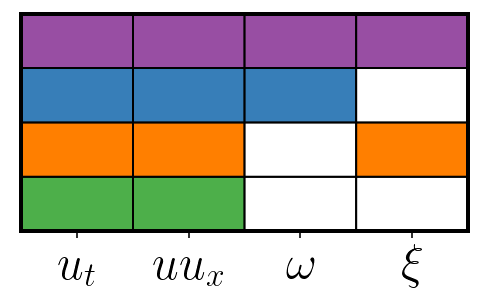

In [23]:
# balance_models has ones for active terms in each model
# model_index maps from GMM identification to the SPCA model
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print active terms in each balance model
for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: print('No dynamics')

gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

plt.figure(figsize=(4, 2))
plt.pcolor(gridmap[:, :], vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=24)
#plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
#plt.gca().set_yticklabels(range(nc), fontsize=20)
plt.gca().set_yticks([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
    
plt.show()

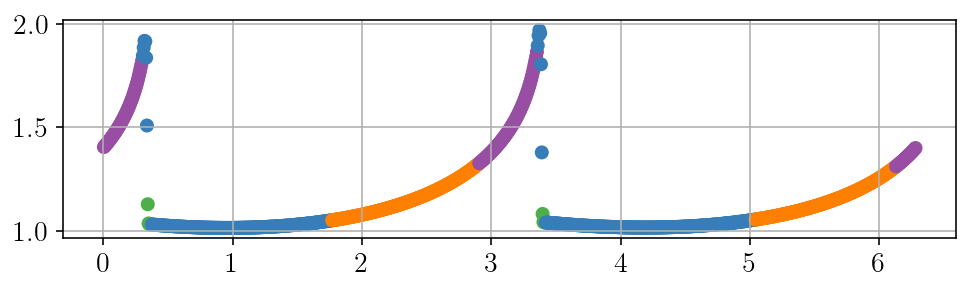

In [26]:
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [len(x), len(t)])+1

# Slice
idx = np.nonzero(tau>18)[0][0]
plt.figure(figsize=(8, 2))
plt.scatter(x, u[:, idx], c=balancemap[:, idx], vmin=-0.5, vmax=cm.N-0.5, cmap=cm)
plt.grid()

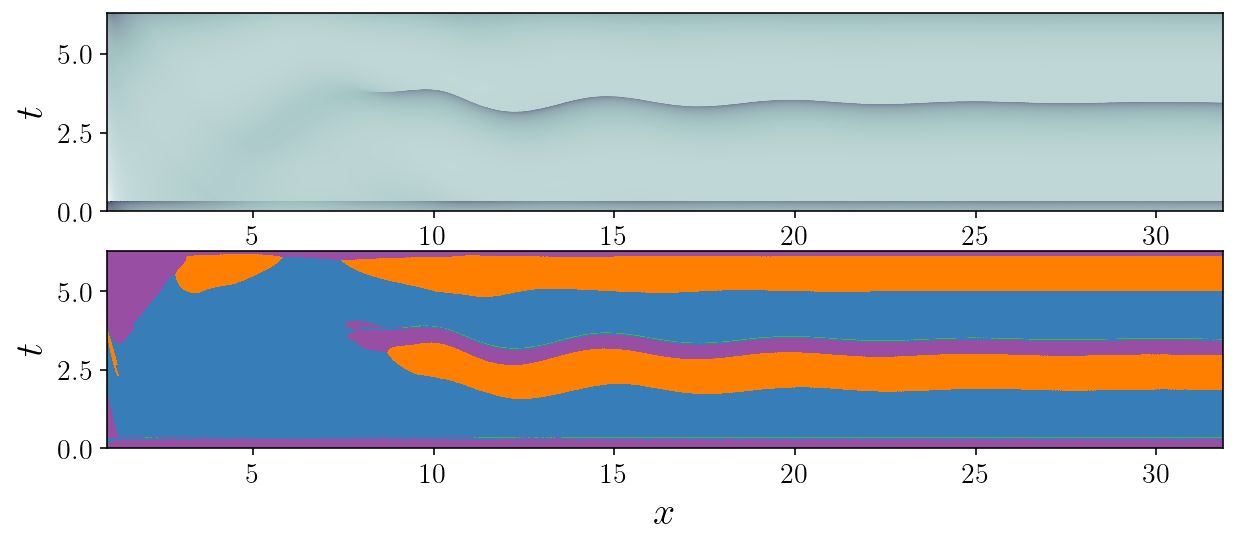

In [27]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.pcolor(tau, x, u, cmap='bone_r', shading='auto')
plt.ylabel('$t$')

plt.subplot(212)
plt.pcolor(tau, x, balancemap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$t$')

#plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.show()

# Wave annihilation

In [2]:
data = sio.loadmat('annihilation.mat')
u = data['u']
z = data['z'] # Combustion variable
t = data['t'][0]
x = data['x'][0]
D = data['D'][0][0]
L = data['L'][0][0]
s = data['s'][0][0]
nu = data['nu'][0][0]

dx = x[1]-x[0]
dt = t[1]-t[0]
N = len(x)

mask = np.nonzero(t>3)[0]
t = t[mask]
u = u[:, mask]
z = z[:, mask]

In [27]:
D/L

0.3183098861837907

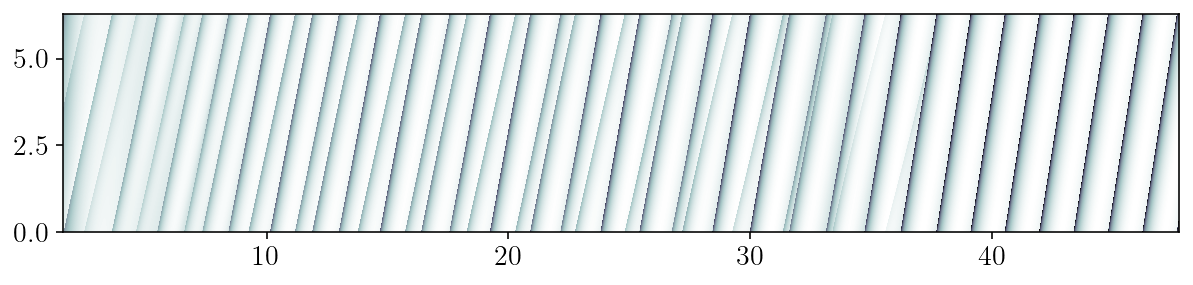

In [3]:
tau = t*D/L

fig, ax0 = plt.subplots(nrows=1, figsize=(10, 2))
im = ax0.pcolormesh(tau, x, u, cmap='bone_r', shading='auto')
#plt.xlim([0, 30])

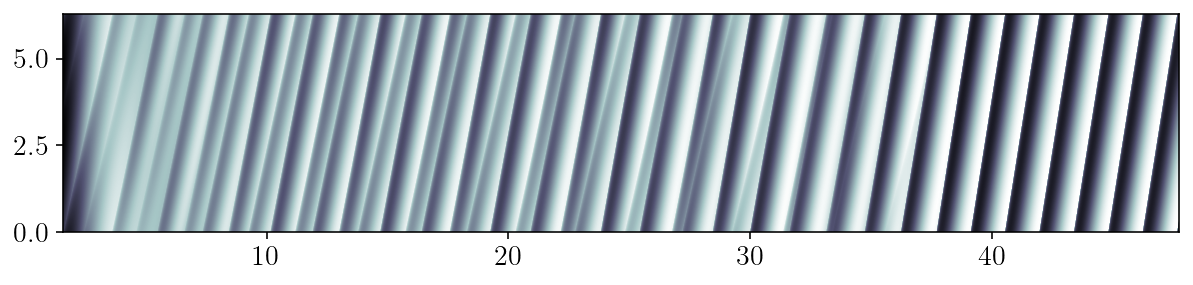

In [4]:
fig, ax0 = plt.subplots(nrows=1, figsize=(10, 2))
im = ax0.pcolormesh(tau, x, z, cmap='bone_r', shading='auto')
#plt.xlim([0, 30])

In [5]:
# Compute derivatives
k = 2*np.pi*fftfreq(N, dx)

ux = np.zeros(u.shape)
#uxx = np.zeros(u.shape)
ut = np.zeros(u.shape)
for i in range(len(t)):
    ux[:, i] = np.gradient(u[:, i], dx)
    #uxx[:, i] = np.gradient(ux[:, i], dx)
    #ux[:, i] = np.real( ifft( (1j*k*fft(u[:, i])) ) )
    
for i in range(len(x)):
    ut[i, :] = np.gradient(u[i, :], dt)

### Align the fields

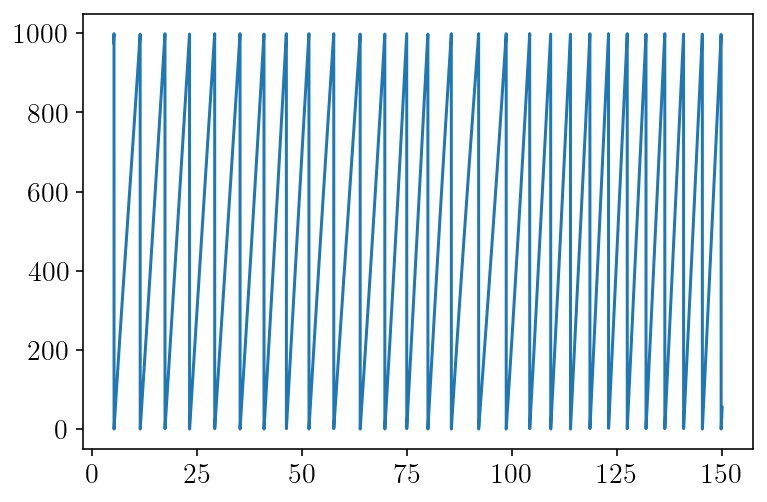

In [6]:
max_idx = np.zeros(len(t), dtype=int)
max_idx[0] = np.argmax(u[:, 0])

window = 20
for i in range(1, len(t)):
    idx_range = np.mod( np.arange(max_idx[i-1]-window, max_idx[i-1]+window, dtype=int), N)
    max_idx[i] = idx_range[ np.argmax(u[idx_range, i]) ]
    
plt.plot(t, max_idx)

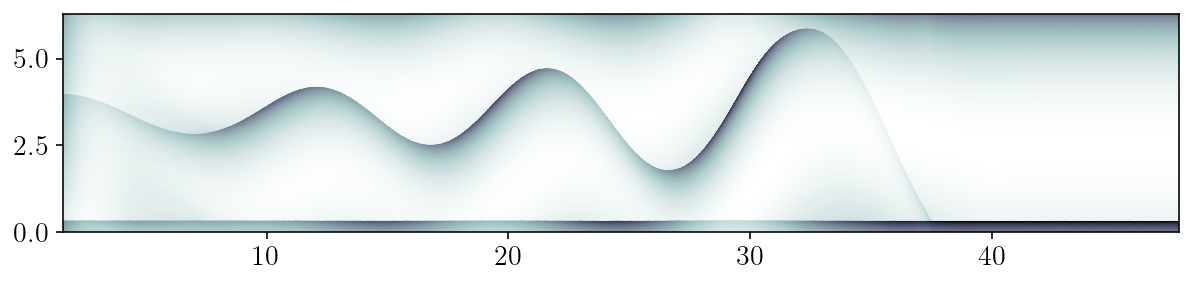

In [7]:
offset = 50
for i in range(len(t)):
    idx_range = np.mod( np.arange(N, dtype=int) + max_idx[i] - offset, N)
    u[:, i] = u[idx_range, i]
    ut[:, i] = ut[idx_range, i]
    ux[:, i] = ux[idx_range, i]
    #uxx[:, i] = uxx[idx_range, i]
    z[:, i] = z[idx_range, i]
    
fig, ax0 = plt.subplots(nrows=1, figsize=(10, 2))
im = ax0.pcolormesh(tau, x, u, cmap='bone_r', shading='auto')

In [8]:
# Parameters
a = 0.3
uc = 1.1
up = 0.5
k = 5
e = 0.11

gain = (1-z)*np.exp( (u - uc)/a )
loss = -e*u**2

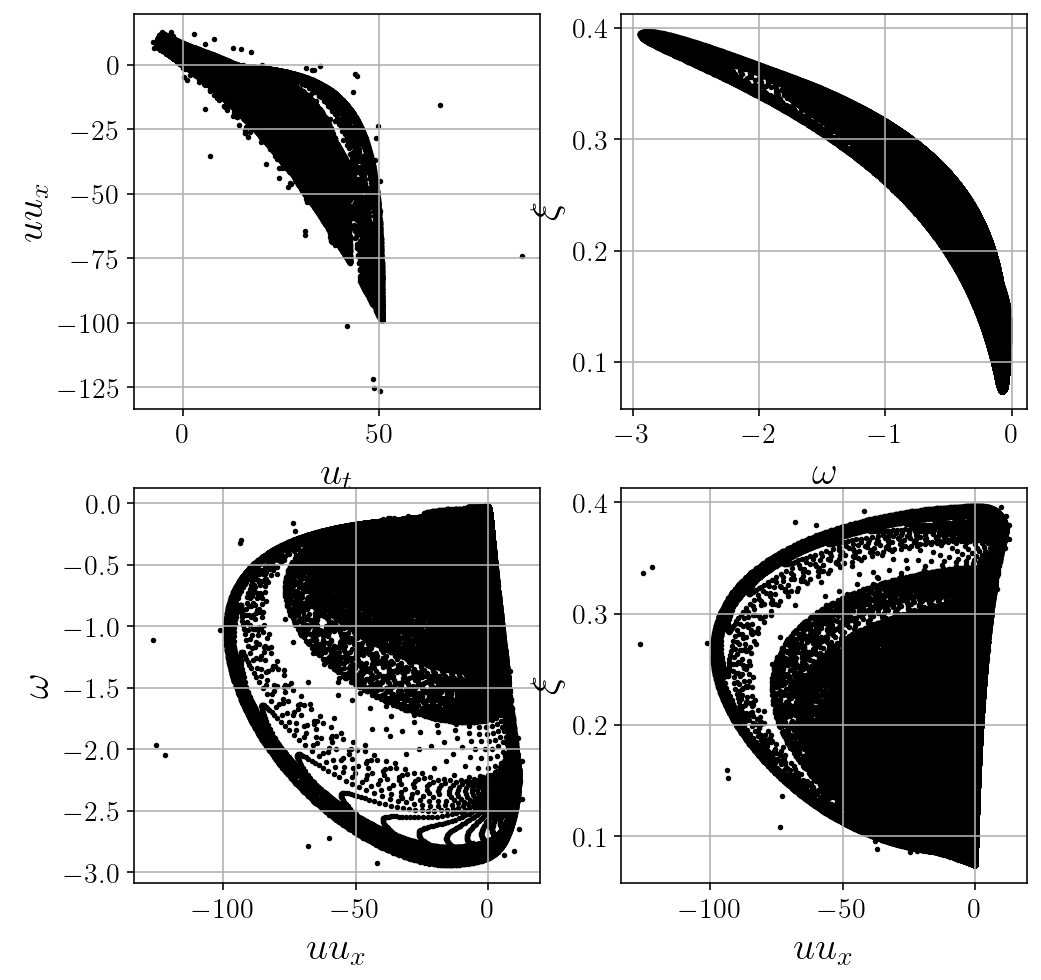

In [9]:
# features are [acceleration, advection, viscous]
features = np.vstack([ut.flatten(),
                      (u*ux).flatten(),
                      -gain.flatten(),
                      -loss.flatten()]).T
                      #-nu*uxx.flatten()]).T
nfeatures = features.shape[1]
labels = ['$u_t$', '$u u_x$', r'$\omega$', r'$\xi$']#, r'$\nu u_{xx}$']

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.scatter(features[:, 0], features[:,1], 3, 'k')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()

plt.subplot(222)
plt.scatter(features[:, 2], features[:,3], 3, 'k')
plt.xlabel(labels[2])
plt.ylabel(labels[3])
plt.grid()

plt.subplot(223)
plt.scatter(features[:, 1], features[:,2], 3, 'k')
plt.xlabel(labels[1])
plt.ylabel(labels[2])
plt.grid()

plt.subplot(224)
plt.scatter(features[:, 1], features[:,3], 3, 'k')
plt.xlabel(labels[1])
plt.ylabel(labels[3])
plt.grid()

plt.show()

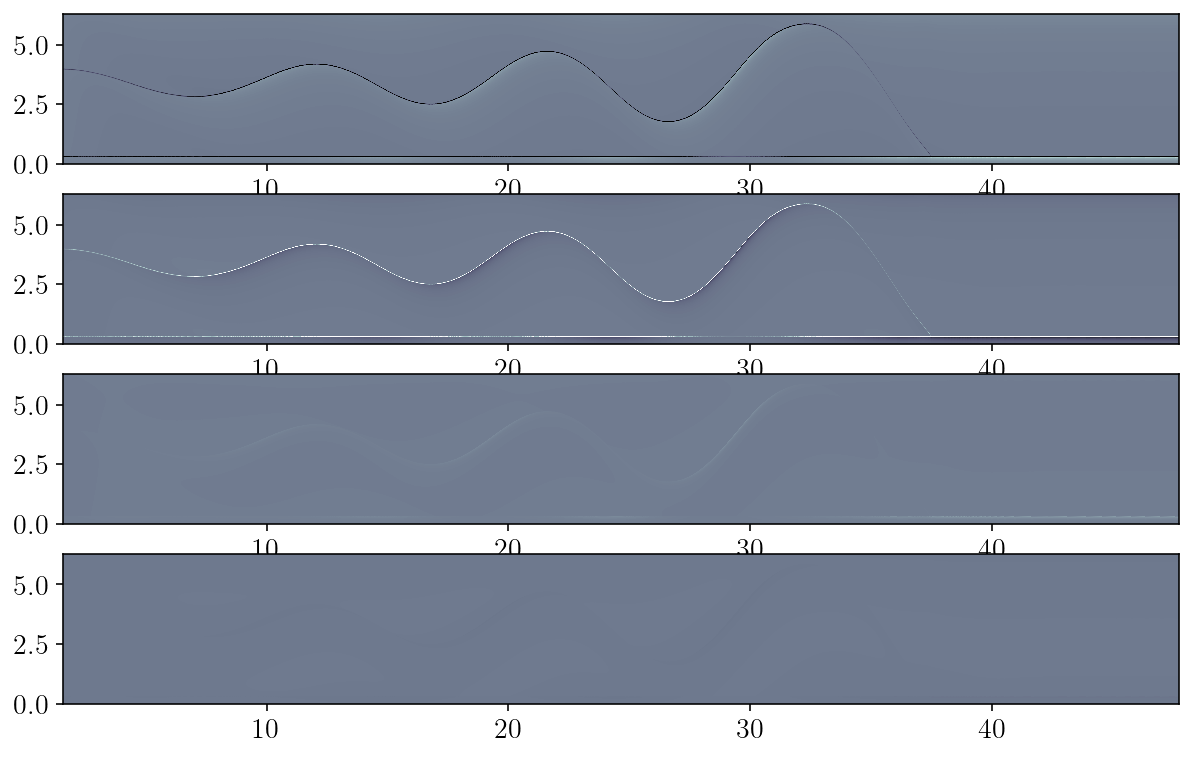

In [10]:
# Plot fields
plt.figure(figsize=(10, 8))

for i in range(4):
    plt.subplot(5, 1, i+1)
    field = np.reshape(features[:, i], [len(x), len(t)])
    plt.pcolormesh(tau, x, field, cmap='bone_r', shading='auto',
                  vmin =-10, vmax=10)

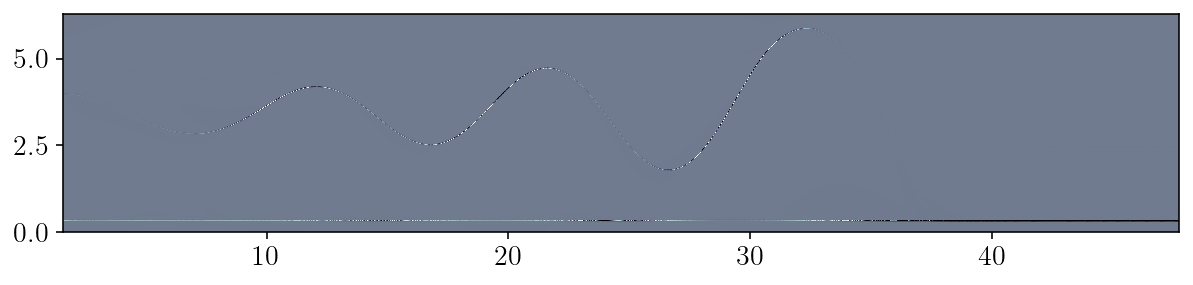

In [11]:
# check closure
# Plot fields
plt.figure(figsize=(10, 2))
field = np.reshape(np.sum(features, axis=1), [len(x), len(t)])
plt.pcolormesh(tau, x, field, cmap='bone_r', shading='auto',
              vmin =-10, vmax=10)

In [12]:
nc = 8  # Number of clusters

seed = np.random.randint(2**32)
seed = 3363731438  # Random seed (nc=8)
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed)
s
# Randomly subsample data
sample_pct = 0.01
# PERMUTATION
rand_sample = permutation(features.shape[0])[:int(sample_pct*features.shape[0])]
model.fit(features[rand_sample, :])

3363731438


GaussianMixture(n_components=8, random_state=3363731438)

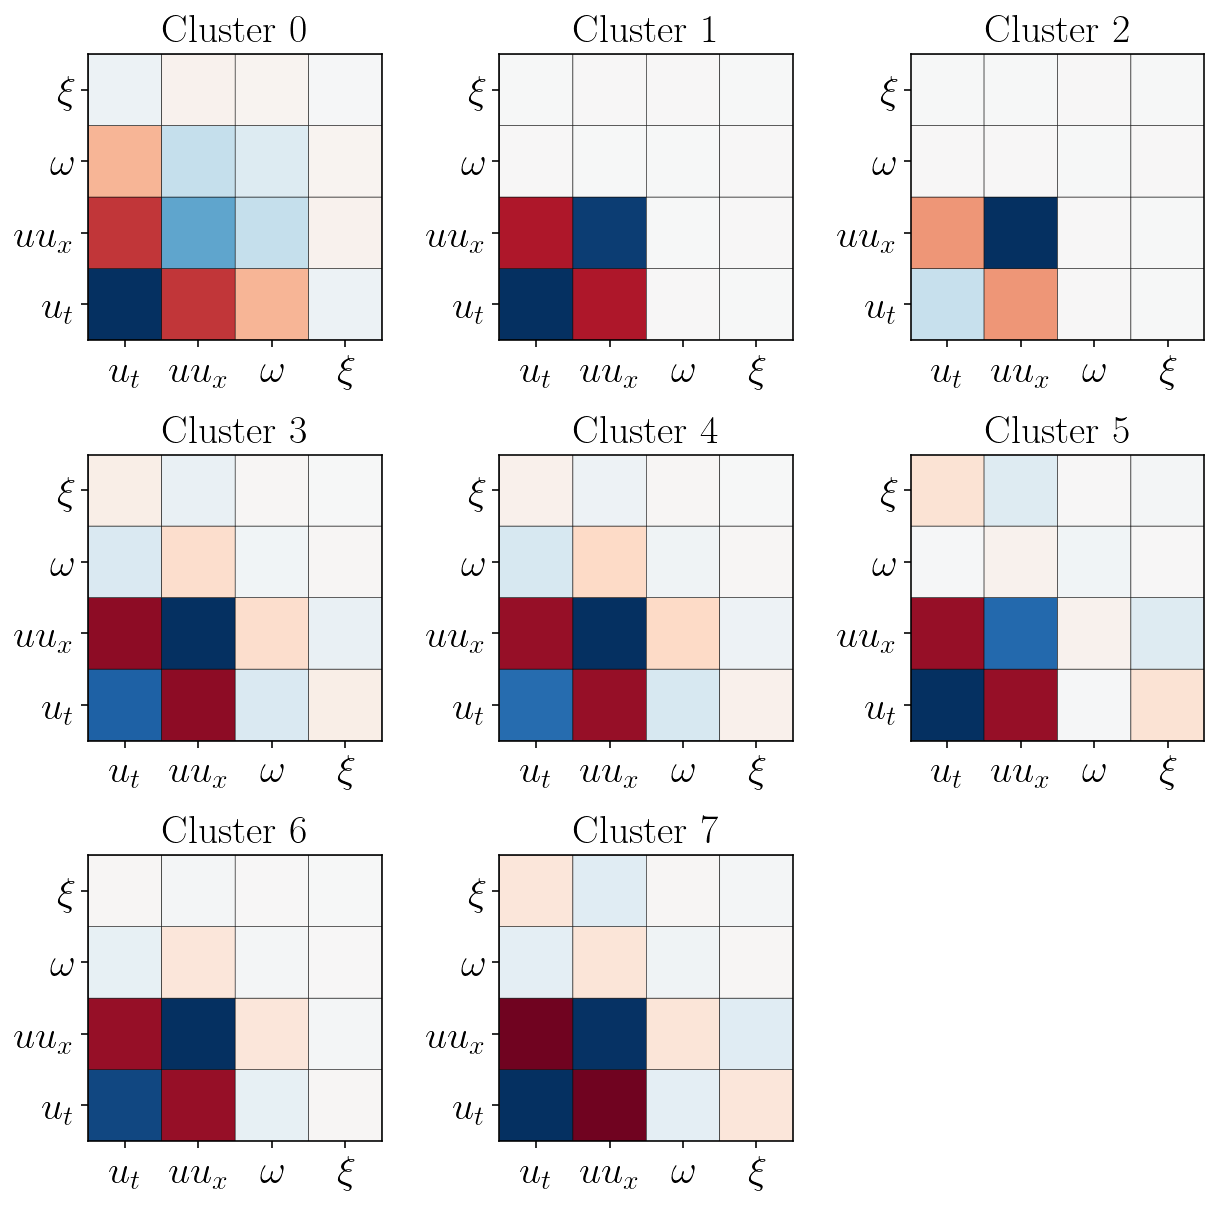

In [13]:
# Plot covariance matrices
plt.figure(figsize=(10, 10))
for i in range(nc):
    plt.subplot(3, 3, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu', edgecolors='k')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels, fontsize=20)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticklabels(labels, fontsize=20)
    plt.gca().set_title('Cluster {0}'.format(i))
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.show()

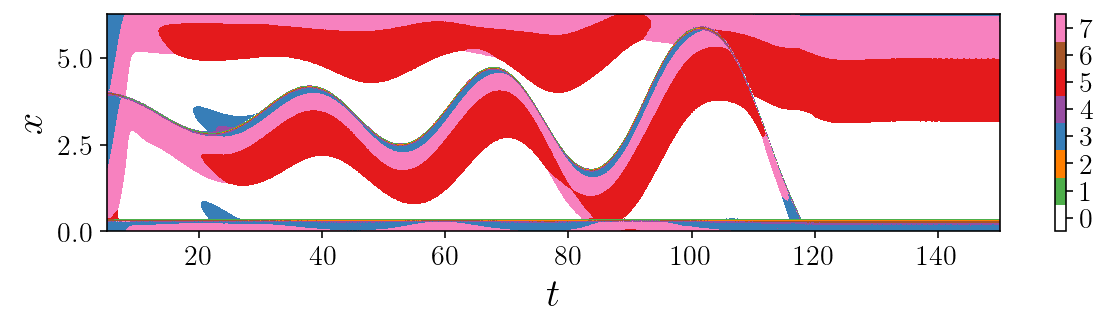

In [14]:
# Colormap of clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [len(x), len(t)])

plt.figure(figsize=(10, 2))
plt.pcolor(t, x, clustermap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, shading='auto')
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.colorbar(boundaries=np.arange(-0.5, nc+0.5), ticks=np.arange(0, nc))
#plt.xlim([-0.3, 2])
#plt.ylim([0, 0.04])
plt.show()

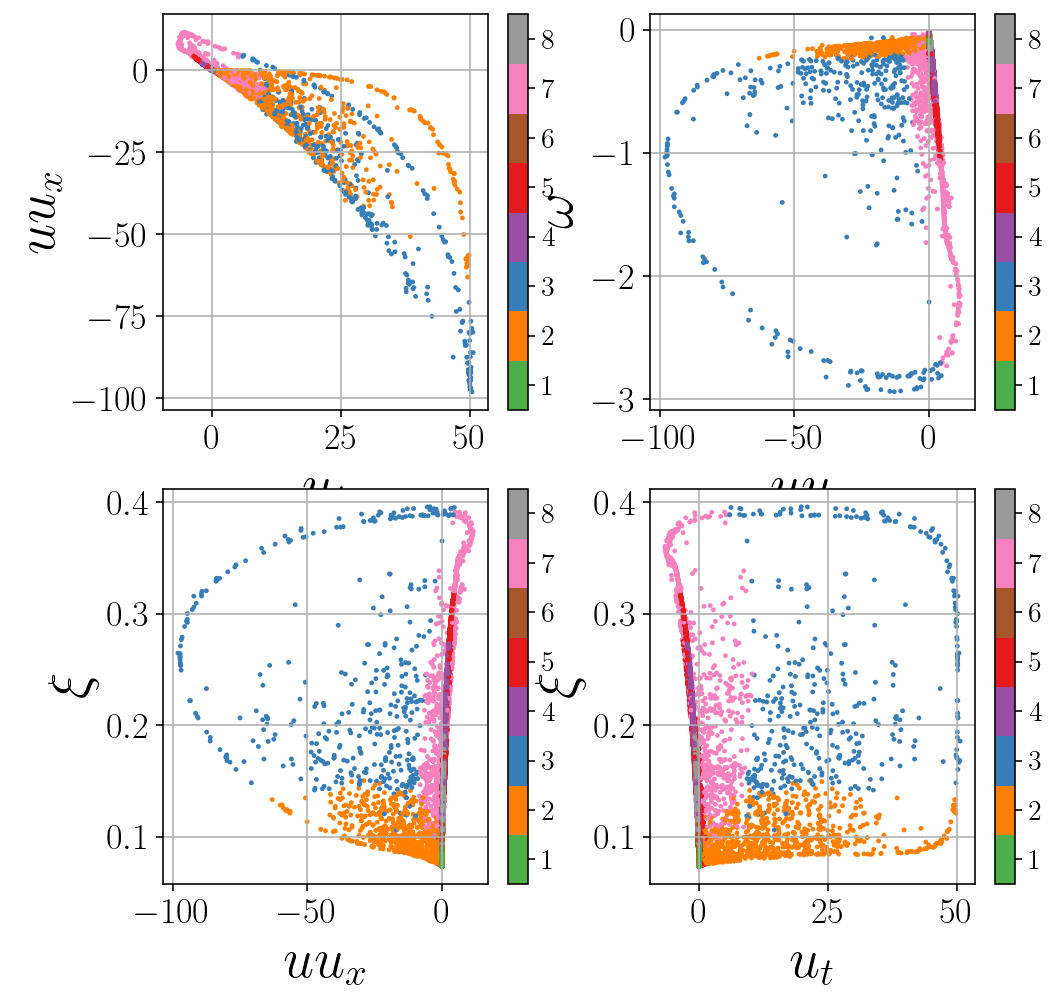

In [15]:
markersize = 2
fontsize = 28
# 2D views of feature space

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.scatter(features[rand_sample, 0], features[rand_sample,1], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[1], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()


plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[rand_sample, 1], features[rand_sample,2], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[1], fontsize=fontsize)
plt.ylabel(labels[2], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(223)
plt.scatter(features[rand_sample, 1], features[rand_sample,3], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[1], fontsize=fontsize)
plt.ylabel(labels[3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)


plt.subplot(224)
plt.scatter(features[rand_sample, 0], features[rand_sample,3], markersize,
            cluster_idx[rand_sample]+1, cmap=cm)
plt.xlabel(labels[0], fontsize=fontsize)
plt.ylabel(labels[3], fontsize=fontsize)
plt.clim([-0.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+2))
plt.grid()

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.show()

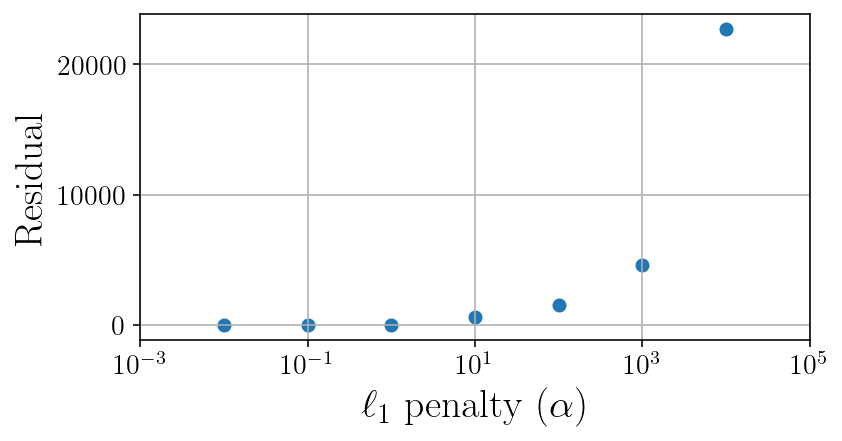

In [16]:
alphas = [1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]  # L1 regularization terms
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        # Fit the SPCA model using only the points in this GMM cluster
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])
        spca.fit(cluster_features)
        
        # Find directions in equation space with nonzero variance for the first principal component
        #   (These correspond to active terms in this region)
        active_terms = np.nonzero(spca.components_[0])[0]
        
        # The residual is defined as the norm of what was discarded
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ penalty ($\alpha$)')
plt.ylabel('Residual')
plt.gca().set_xscale('log')
plt.xlim([1e-3, 1e5])
plt.grid()
plt.show()

In [17]:
alpha_opt = 10

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')
        

GMM Cluster 0:
['$u_t$', '$u u_x$', '$\\omega$']
GMM Cluster 1:
['$u_t$', '$u u_x$']
GMM Cluster 2:
['$u_t$', '$u u_x$']
GMM Cluster 3:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']
GMM Cluster 4:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']
GMM Cluster 5:
['$u_t$', '$u u_x$', '$\\xi$']
GMM Cluster 6:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']
GMM Cluster 7:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']


[[1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]]
SPCA Cluster 0:
['$u_t$', '$u u_x$']
SPCA Cluster 1:
['$u_t$', '$u u_x$', '$\\xi$']
SPCA Cluster 2:
['$u_t$', '$u u_x$', '$\\omega$']
SPCA Cluster 3:
['$u_t$', '$u u_x$', '$\\omega$', '$\\xi$']


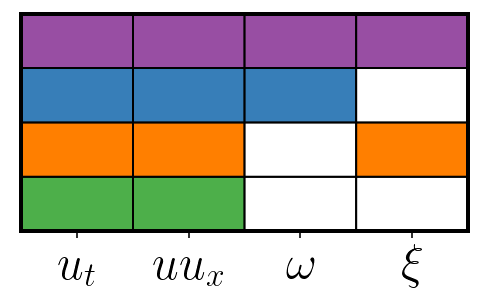

In [18]:
# balance_models has ones for active terms in each model
# model_index maps from GMM identification to the SPCA model
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

# Print active terms in each balance model
for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: print('No dynamics')

gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

plt.figure(figsize=(4, 2))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=24)
#plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
#plt.gca().set_yticklabels(range(nc), fontsize=20)
plt.gca().set_yticks([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
    
plt.show()

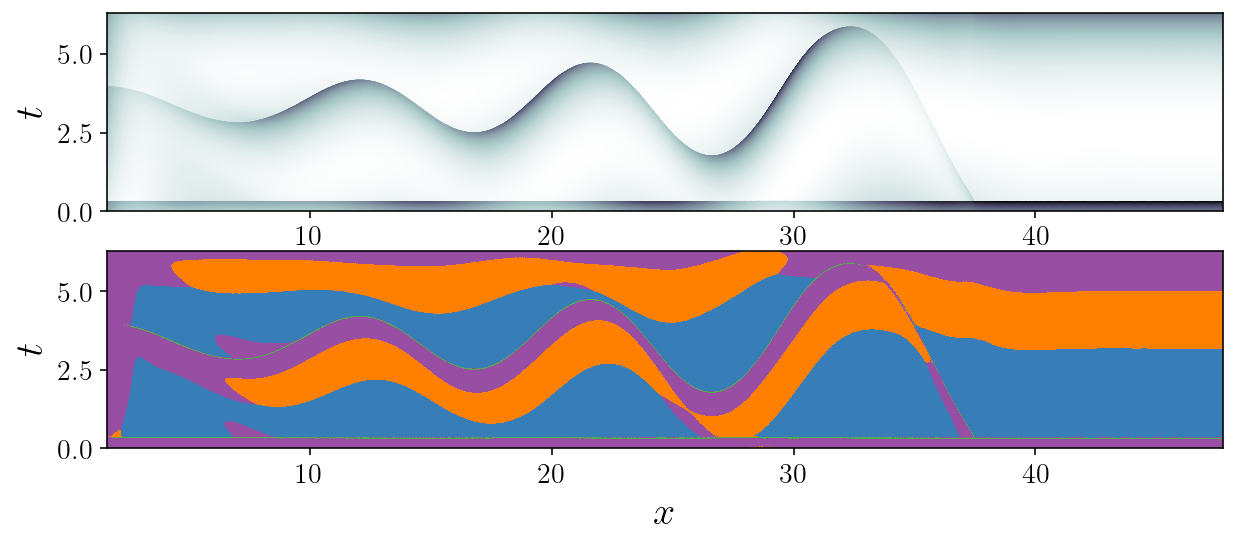

In [19]:
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [len(x), len(t)])+1

plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.pcolor(tau, x, u, cmap='bone_r', shading='auto')
plt.ylabel('$t$')

plt.subplot(212)
plt.pcolor(tau, x, balancemap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, shading='auto')
plt.xlabel('$x$')
plt.ylabel('$t$')

#plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.show()

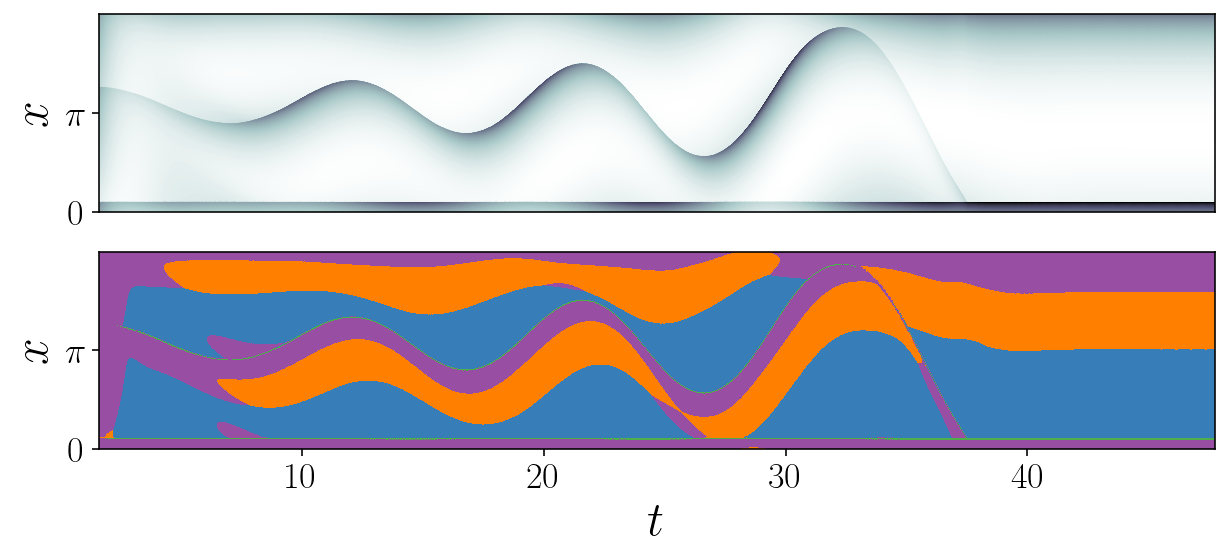

In [20]:
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [len(x), len(t)])+1

plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.pcolor(tau, x, u, cmap='bone_r', shading='auto')
plt.ylabel('$x$', fontsize=24)
plt.yticks([0, np.pi])
plt.gca().set_yticklabels(['0', r'$\pi$'], fontsize=18)
plt.xticks([])


plt.subplot(212)
plt.pcolor(tau, x, balancemap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, shading='auto')
plt.xlabel('$t$', fontsize=24)
plt.ylabel('$x$', fontsize=24)
plt.yticks([0, np.pi])
plt.gca().set_yticklabels(['0', r'$\pi$'], fontsize=18)
plt.xticks(fontsize=18)

#plt.colorbar(boundaries=np.arange(-0.5, nmodels+0.5), ticks=np.arange(0, nmodels))
plt.show()